In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, ConcatDataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import math

DATASET_REPEAT_COUNT = 1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

train_dataset = datasets.Flowers102(
    root="./flower_dataset", split="train", download=True, transform=transform
)
val_dataset = datasets.Flowers102(
    root="./flower_dataset", split="val", download=True, transform=transform
)
test_dataset = datasets.Flowers102(
    root="./flower_dataset", split="test", download=True, transform=transform
)

train_dataset = ConcatDataset([train_dataset, val_dataset, test_dataset])

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

print(f"훈련 데이터 개수: {len(train_dataset)}")

훈련 데이터 개수: 8189


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

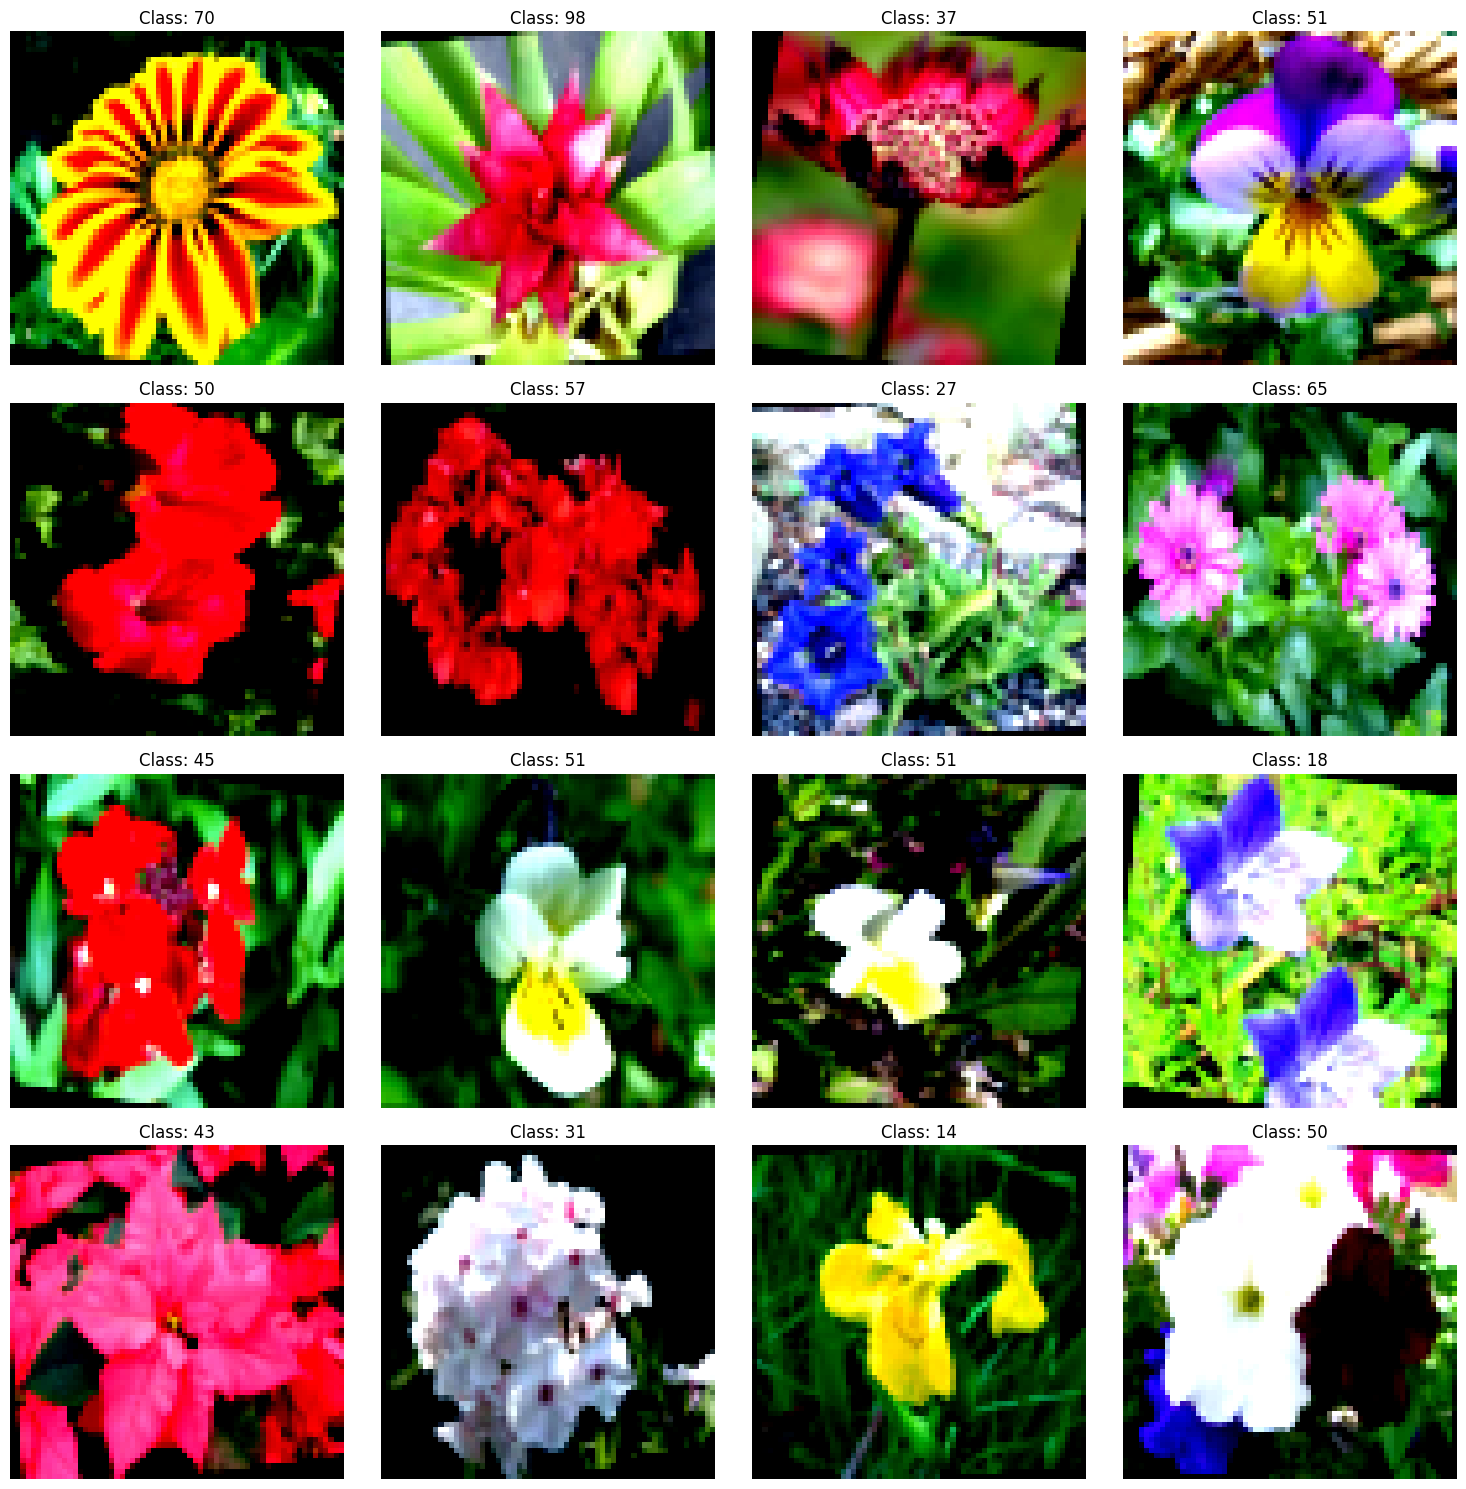

배치 크기: 64
이미지 크기: 3x64x64


In [2]:
import matplotlib.pyplot as plt
import numpy as np

dataiter = iter(train_loader)
images, labels = next(dataiter)


def imshow(img, denormalize=True):
    if denormalize:
        img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis("off")


def imshow_grid(images):
    fig = plt.figure(figsize=(15, 15))
    grid_size = min(images.size(0), 16)
    for i in range(grid_size):
        ax = fig.add_subplot(4, 4, i + 1)
        imshow(images[i])
        ax.set_title(f"Class: {labels[i]}")
    plt.tight_layout()
    plt.show()


imshow_grid(images)


print(f"배치 크기: {images.size(0)}")
print(f"이미지 크기: {images.size(1)}x{images.size(2)}x{images.size(3)}")

In [3]:
def cosine_diffusion_schedule(diffusion_times):
    signal_rates = torch.cos(diffusion_times * math.pi / 2)
    noise_rates = torch.sin(diffusion_times * math.pi / 2)
    return noise_rates, signal_rates


def offset_cosine_diffusion_schedule(diffusion_times):
    min_signal_rate = 0.02
    max_signal_rate = 0.95

    start_angle = math.acos(max_signal_rate)
    end_angle = math.acos(min_signal_rate)

    diffusion_angles = start_angle + diffusion_times * (end_angle - start_angle)

    signal_rates = torch.cos(diffusion_angles)
    noise_rates = torch.sin(diffusion_angles)

    return noise_rates, signal_rates

### UNet


In [4]:
import math


class SinusoidalEmbedding(nn.Module):
    def __init__(self, n_channels):
        super().__init__()
        self.n_channels = n_channels
        self.lin1 = nn.Linear(self.n_channels // 4, self.n_channels)
        self.act = nn.SiLU()
        self.lin2 = nn.Linear(self.n_channels, self.n_channels)

    def forward(self, t):
        t = t.view(-1)

        half_dim = self.n_channels // 8
        emb = math.log(10_000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=t.device) * -emb)
        emb = t[:, None] * emb[None, :]
        emb = torch.cat([emb.sin(), emb.cos()], dim=1)

        emb = self.act(self.lin1(emb))
        emb = self.lin2(emb)

        return emb


class ResidualBlock(nn.Module):
    def __init__(
        self, in_channels, out_channels, time_channels, n_groups=8, dropout=0.1
    ):
        super().__init__()
        self.norm1 = nn.GroupNorm(n_groups, in_channels)
        self.act1 = nn.SiLU()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)

        self.norm2 = nn.GroupNorm(n_groups, out_channels)
        self.act2 = nn.SiLU()
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)

        if in_channels != out_channels:
            self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        else:
            self.shortcut = nn.Identity()

        self.time_emb = nn.Linear(time_channels, out_channels)
        self.time_act = nn.SiLU()

        self.dropout = nn.Dropout(dropout)

    def forward(self, x, t):
        h = self.conv1(self.act1(self.norm1(x)))
        h += self.time_emb(self.time_act(t))[:, :, None, None]
        h = self.conv2(self.dropout(self.act2(self.norm2(h))))
        return h + self.shortcut(x)


class AttentionBlock(nn.Module):
    def __init__(self, n_channels, n_heads=1, d_k=None, n_groups=32):
        super().__init__()
        if d_k is None:
            d_k = n_channels

        self.norm = nn.GroupNorm(n_groups, n_channels)
        self.projection = nn.Linear(n_channels, n_heads * d_k * 3)
        self.output = nn.Linear(n_heads * d_k, n_channels)

        self.scale = d_k**-0.5

        self.n_heads = n_heads
        self.d_k = d_k

    def forward(self, x, t=None):
        _ = t

        batch_size, n_channels, height, width = x.shape
        x = x.view(batch_size, n_channels, -1).permute(0, 2, 1)
        qkv = self.projection(x).view(batch_size, -1, self.n_heads, 3 * self.d_k)
        q, k, v = torch.chunk(qkv, 3, dim=-1)
        attn = torch.einsum("bihd,bjhd->bijh", q, k) * self.scale
        attn = attn.softmax(dim=2)
        res = torch.einsum("bijh,bjhd->bihd", attn, v)
        res = res.view(batch_size, -1, self.n_heads * self.d_k)
        res = self.output(res)

        res += x
        res = res.permute(0, 2, 1).view(batch_size, n_channels, height, width)

        return res


class DownBlock(nn.Module):
    def __init__(self, in_channels, out_channels, time_channels, has_attn):
        super().__init__()
        self.res = ResidualBlock(in_channels, out_channels, time_channels)
        if has_attn:
            self.attn = AttentionBlock(out_channels)
        else:
            self.attn = nn.Identity()

    def forward(self, x, t):
        x = self.res(x, t)
        x = self.attn(x)
        return x


class UpBlock(nn.Module):
    def __init__(self, in_channels, out_channels, time_channels, has_attn):
        super().__init__()
        self.res = ResidualBlock(
            in_channels + out_channels, out_channels, time_channels
        )
        if has_attn:
            self.attn = AttentionBlock(out_channels)
        else:
            self.attn = nn.Identity()

    def forward(self, x, t):
        x = self.res(x, t)
        x = self.attn(x)
        return x


class MiddleBlock(nn.Module):
    def __init__(self, n_channels, time_channels):
        super().__init__()
        self.res1 = ResidualBlock(n_channels, n_channels, time_channels)
        self.attn = AttentionBlock(n_channels)
        self.res2 = ResidualBlock(n_channels, n_channels, time_channels)

    def forward(self, x, t):
        x = self.res1(x, t)
        x = self.attn(x)
        x = self.res2(x, t)
        return x


class Upsample(nn.Module):
    def __init__(self, n_channels):
        super().__init__()
        self.conv = nn.ConvTranspose2d(n_channels, n_channels, 4, 2, 1)

    def forward(self, x, t):
        _ = t
        return self.conv(x)


class Downsample(nn.Module):
    def __init__(self, n_channels):
        super().__init__()
        self.conv = nn.Conv2d(n_channels, n_channels, 3, 2, 1)

    def forward(self, x, t):
        _ = t
        return self.conv(x)


class UNet(nn.Module):
    def __init__(
        self,
        image_channels=3,
        n_channels=32,
        ch_mults=(1, 2, 2, 4),
        use_attns=(False, False, True, True),
        n_blocks=2,
    ):
        super().__init__()
        n_resolutions = len(ch_mults)

        self.image_proj = nn.Conv2d(
            image_channels, n_channels, kernel_size=3, padding=1
        )
        self.time_emb = SinusoidalEmbedding(n_channels * 4)

        down = []
        out_channels = in_channels = n_channels

        for i in range(n_resolutions):
            out_channels = in_channels * ch_mults[i]

            for _ in range(n_blocks):
                down.append(
                    DownBlock(in_channels, out_channels, n_channels * 4, use_attns[i])
                )
                in_channels = out_channels

            if i < n_resolutions - 1:
                down.append(Downsample(in_channels))

        self.down = nn.ModuleList(down)

        self.middle = MiddleBlock(out_channels, n_channels * 4)

        up = []
        in_channels = out_channels

        for i in reversed(range(n_resolutions)):
            out_channels = in_channels
            for _ in range(n_blocks):
                up.append(
                    UpBlock(in_channels, out_channels, n_channels * 4, use_attns[i])
                )

            out_channels = in_channels // ch_mults[i]
            up.append(UpBlock(in_channels, out_channels, n_channels * 4, use_attns[i]))
            in_channels = out_channels

            if i > 0:
                up.append(Upsample(in_channels))

        self.up = nn.ModuleList(up)

        self.norm = nn.GroupNorm(8, n_channels)
        self.act = nn.SiLU()
        self.final = nn.Conv2d(in_channels, image_channels, kernel_size=3, padding=1)

    def forward(self, t, x):
        t = self.time_emb(t)
        x = self.image_proj(x)

        h = [x]

        for m in self.down:
            x = m(x, t)
            h.append(x)

        x = self.middle(x, t)

        for m in self.up:
            if isinstance(m, Upsample):
                x = m(x, t)
            else:
                s = h.pop()
                x = torch.cat([x, s], dim=1)
                x = m(x, t)

        return self.final(self.act(self.norm(x)))

In [5]:
class DiffusionModel(nn.Module):
    def __init__(self, device="cuda"):
        super(DiffusionModel, self).__init__()

        self.network = UNet().to(device)
        self.diffusion_schedule = offset_cosine_diffusion_schedule
        self.loss = nn.L1Loss()
        self.optim = optim.AdamW(self.network.parameters(), lr=3e-5)

        self.device = device

    def forward_process(self, images):
        noises = torch.randn_like(images).to(self.device)
        diffusion_times = torch.rand((images.shape[0], 1, 1, 1)).to(self.device)
        noise_rates, signal_rates = self.diffusion_schedule(diffusion_times)
        noisy_images = signal_rates * images + noise_rates * noises

        return noisy_images, noise_rates, signal_rates

    def denoise(self, noisy_images, noise_rates, signal_rates):
        noisy_images = noisy_images.to(self.device)
        noise_rates = noise_rates.to(self.device)
        signal_rates = signal_rates.to(self.device)

        pred_noises = self.network(
            noise_rates**2,
            noisy_images,
        )
        pred_images = (noisy_images - noise_rates * pred_noises) / signal_rates

        return pred_noises, pred_images

    def train_cycle(self, images):
        noises = torch.randn_like(images).to(self.device)
        batch_size = images.shape[0]

        diffusion_times = torch.rand(batch_size, 1, 1, 1).to(self.device)
        diffusion_times = diffusion_times * 0.2 + 0.8
        noise_rates, signal_rates = self.diffusion_schedule(diffusion_times)
        noisy_images = signal_rates * images + noise_rates * noises

        # GRAD BACKWARD
        pred_noises, _ = self.denoise(noisy_images, noise_rates, signal_rates)

        noise_loss = self.loss(pred_noises, noises)

        self.optim.zero_grad()
        noise_loss.backward()

        # GRADIENT CLIPPING
        # max_grad_norm = 2.8
        # utils.clip_grad_norm_(self.network.parameters(), max_grad_norm)

        self.optim.step()

        return noise_loss.item()

    @torch.no_grad()
    def reverse_diffusion(self, initial_noise, diffusion_steps):
        num_images = initial_noise.shape[0]
        step_size = 1.0 / diffusion_steps
        current_images = initial_noise
        for step in range(diffusion_steps):
            diffusion_times = (
                torch.ones((num_images, 1, 1, 1)).to(self.device) - step * step_size
            )
            noise_rates, signal_rates = self.diffusion_schedule(diffusion_times)
            pred_noises, pred_images = self.denoise(
                current_images, noise_rates, signal_rates
            )
            next_diffusion_times = diffusion_times - step_size
            next_noise_rates, next_signal_rates = self.diffusion_schedule(
                next_diffusion_times
            )
            current_images = (
                next_signal_rates * pred_images + next_noise_rates * pred_noises
            )

        return pred_images

    def denormalize(
        self, images, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
    ):
        mean = torch.tensor(mean).view(3, 1, 1).to(self.device)
        std = torch.tensor(std).view(3, 1, 1).to(self.device)

        denormalized = images * std + mean
        denormalized = torch.clamp(denormalized, 0.0, 1.0)

        return denormalized

    @torch.no_grad()
    def generate(self, num_images, diffusion_steps):
        with torch.no_grad():
            initial_noise = torch.randn(num_images, 3, 64, 64).to(self.device)
            generated_images = self.reverse_diffusion(initial_noise, diffusion_steps)
            # generated_images = self.denormalize(generated_images)
            return generated_images

In [6]:
load_model = True

model = DiffusionModel(device=device)

if load_model:
    model.load_state_dict(
        torch.load(
            "./runs/diffusion_training_20240922-2200/diffusion_model_epoch_10.pth"
        )
    )

In [7]:
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
from torchvision.utils import make_grid
import datetime

# TensorBoard
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M")
log_dir = f"runs/diffusion_training_{current_time}"
writer = SummaryWriter(log_dir)

num_epochs = 100
log_interval = 100

losses = []


def create_image_grid(images, denormalize=False):
    if denormalize:
        images = images * 0.5 + 0.5
    images = torch.clamp(images, 0, 1)
    return make_grid(images, nrow=4, normalize=False, padding=2)


for epoch in range(num_epochs):
    epoch_loss = 0
    for batch_idx, (images, _) in enumerate(
        tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
    ):
        images = images.to(device)

        loss = model.train_cycle(images)
        epoch_loss += loss

        if (batch_idx + 1) % log_interval == 0:
            print(
                f"Epoch [{epoch+1}/{num_epochs}], Step [{batch_idx+1}/{len(train_loader)}], Loss: {loss:.4f}"
            )

        losses.append(loss)
        writer.add_scalar("Training Loss", loss, epoch * len(train_loader) + batch_idx)

    avg_epoch_loss = epoch_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_epoch_loss:.4f}")

    with torch.no_grad():
        generated_images = model.generate(16, 100)
        img_grid = create_image_grid(generated_images)
        writer.add_image("Generated Images", img_grid, epoch)

    torch.save(model.state_dict(), f"{log_dir}/diffusion_model_epoch_{epoch+1}.pth")

plt.figure(figsize=(10, 5))
plt.plot(losses)
plt.title("Training Loss")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.savefig(f"{log_dir}/training_loss.png")
plt.close()

writer.close()

Epoch 1/100:  78%|███████▊  | 100/128 [01:44<00:23,  1.19it/s]

Epoch [1/100], Step [100/128], Loss: 0.0613


Epoch 1/100: 100%|██████████| 128/128 [02:09<00:00,  1.01s/it]


Epoch [1/100], Average Loss: 0.0621


Epoch 2/100:  78%|███████▊  | 100/128 [02:29<00:43,  1.57s/it]

Epoch [2/100], Step [100/128], Loss: 0.0615


Epoch 2/100: 100%|██████████| 128/128 [03:05<00:00,  1.45s/it]


Epoch [2/100], Average Loss: 0.0615


Epoch 3/100:  78%|███████▊  | 100/128 [01:52<00:23,  1.20it/s]

Epoch [3/100], Step [100/128], Loss: 0.0664


Epoch 3/100: 100%|██████████| 128/128 [02:15<00:00,  1.06s/it]


Epoch [3/100], Average Loss: 0.0614


Epoch 4/100:  78%|███████▊  | 100/128 [01:23<00:25,  1.11it/s]

Epoch [4/100], Step [100/128], Loss: 0.0617


Epoch 4/100: 100%|██████████| 128/128 [01:50<00:00,  1.16it/s]


Epoch [4/100], Average Loss: 0.0612


Epoch 5/100:  78%|███████▊  | 100/128 [02:32<00:44,  1.60s/it]

Epoch [5/100], Step [100/128], Loss: 0.0576


Epoch 5/100: 100%|██████████| 128/128 [03:13<00:00,  1.51s/it]


Epoch [5/100], Average Loss: 0.0614


Epoch 6/100:  78%|███████▊  | 100/128 [02:36<00:45,  1.61s/it]

Epoch [6/100], Step [100/128], Loss: 0.0591


Epoch 6/100: 100%|██████████| 128/128 [03:10<00:00,  1.49s/it]


Epoch [6/100], Average Loss: 0.0608


Epoch 7/100:  78%|███████▊  | 100/128 [01:42<00:26,  1.07it/s]

Epoch [7/100], Step [100/128], Loss: 0.0620


Epoch 7/100: 100%|██████████| 128/128 [02:07<00:00,  1.00it/s]


Epoch [7/100], Average Loss: 0.0611


Epoch 8/100:  78%|███████▊  | 100/128 [02:23<00:41,  1.49s/it]

Epoch [8/100], Step [100/128], Loss: 0.0668


Epoch 8/100: 100%|██████████| 128/128 [03:06<00:00,  1.46s/it]


Epoch [8/100], Average Loss: 0.0611


Epoch 9/100:  78%|███████▊  | 100/128 [01:40<00:25,  1.11it/s]

Epoch [9/100], Step [100/128], Loss: 0.0628


Epoch 9/100: 100%|██████████| 128/128 [02:05<00:00,  1.02it/s]


Epoch [9/100], Average Loss: 0.0606


Epoch 10/100:  78%|███████▊  | 100/128 [01:37<00:26,  1.05it/s]

Epoch [10/100], Step [100/128], Loss: 0.0586


Epoch 10/100: 100%|██████████| 128/128 [02:08<00:00,  1.00s/it]


Epoch [10/100], Average Loss: 0.0610


Epoch 11/100:   8%|▊         | 10/128 [00:16<03:14,  1.65s/it]


KeyboardInterrupt: 

In [7]:
# Fine-tuned model with high noise strength

model.load_state_dict(
    torch.load("./runs/diffusion_training_20240922-2200/diffusion_model_epoch_1.pth")
)

<All keys matched successfully>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

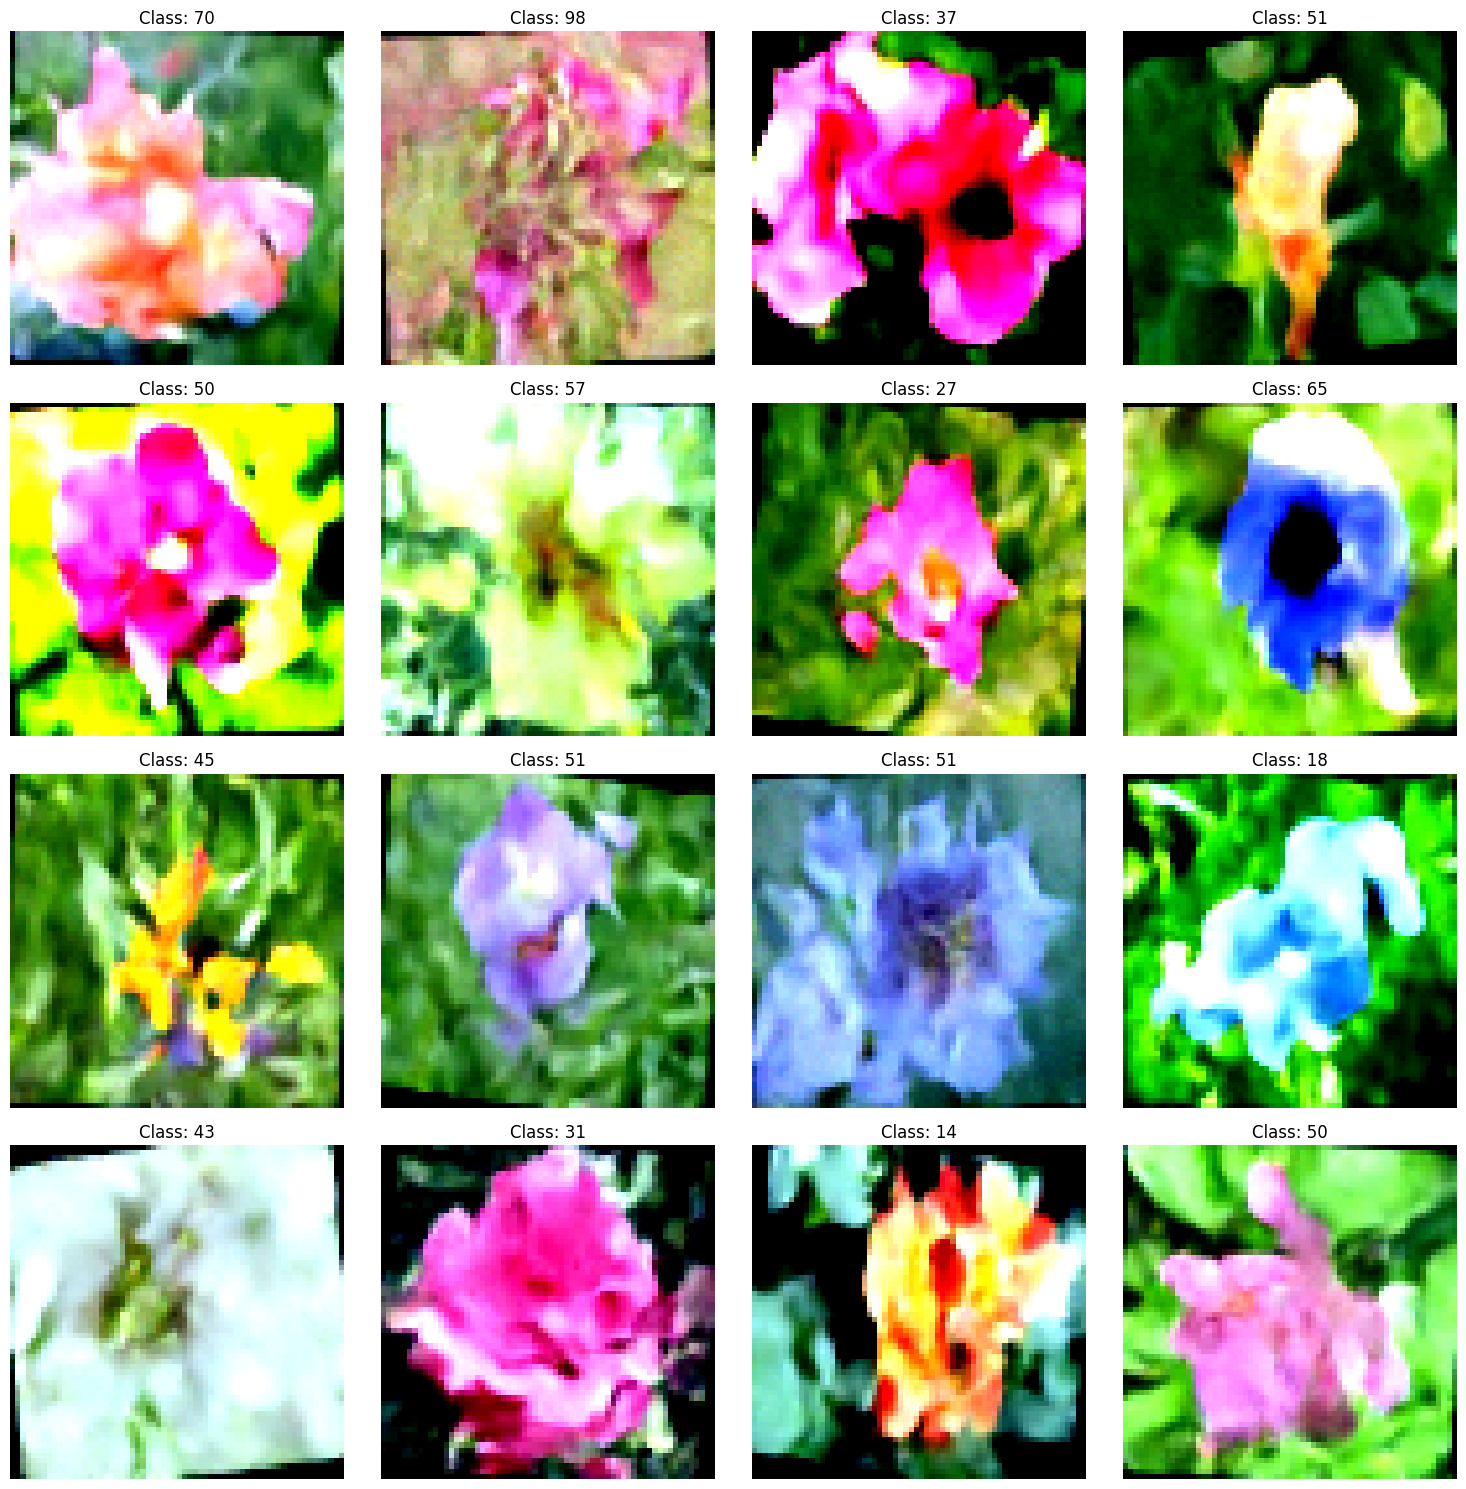

In [8]:
generated_images = model.generate(32, 25)
imshow_grid(generated_images.detach().cpu())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

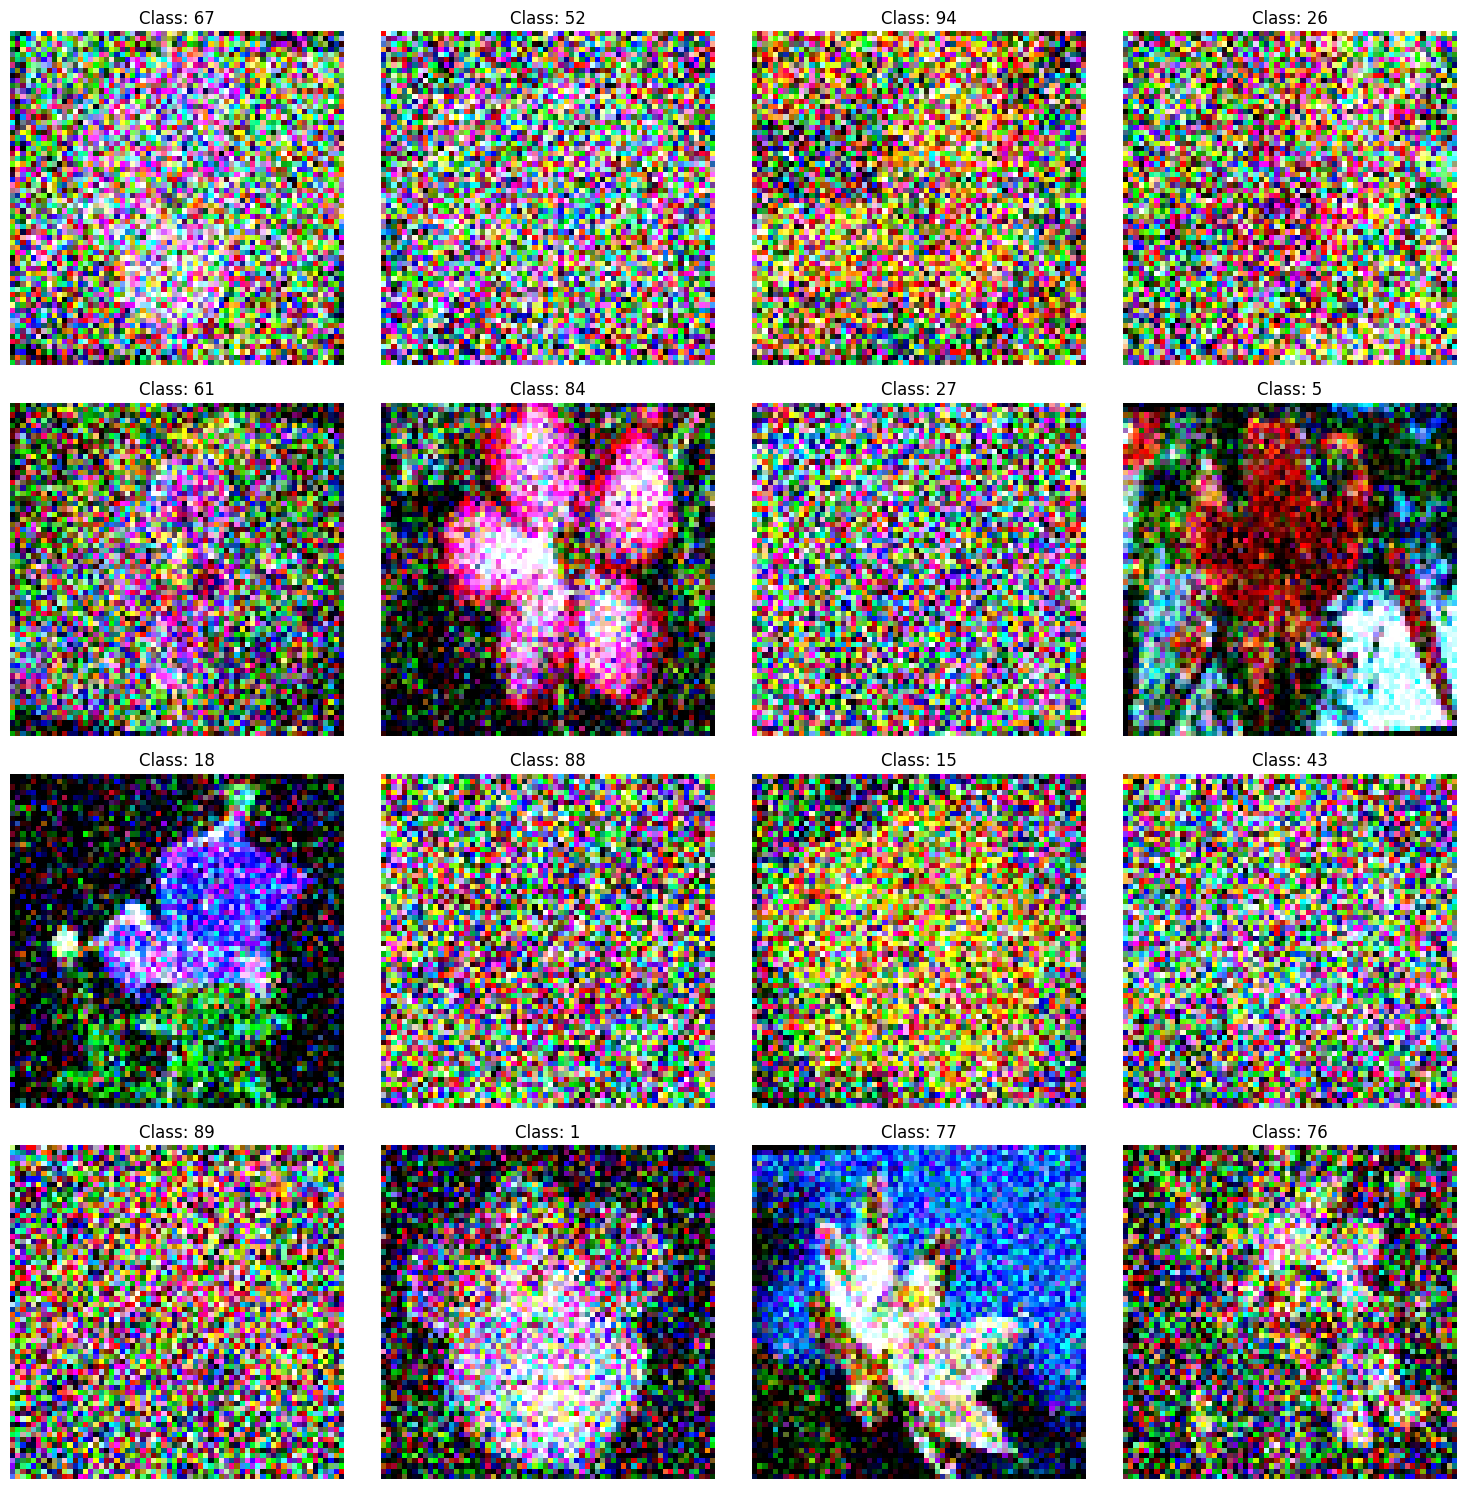

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

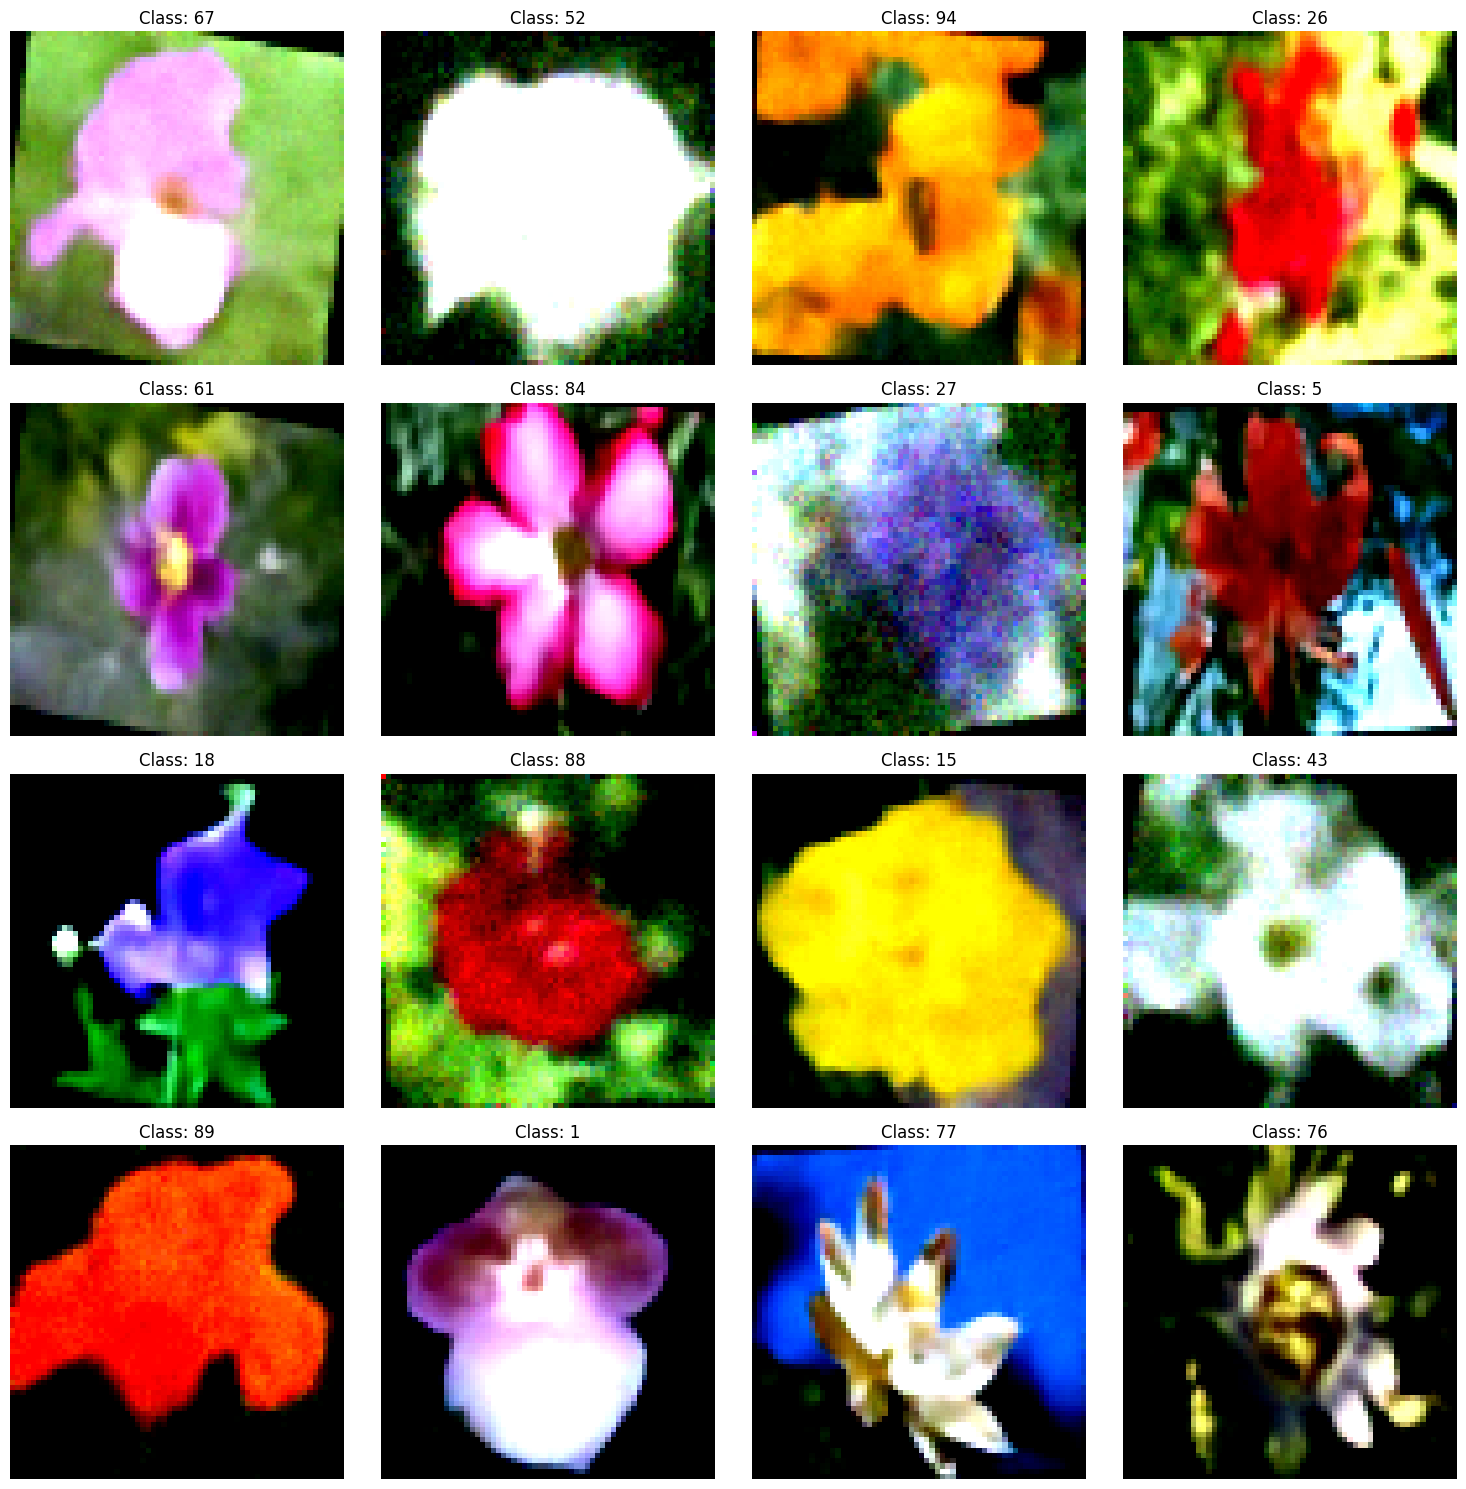

tensor([0.9448, 0.9948, 0.9393, 0.9686, 0.8121, 0.6842, 0.9961, 0.5027, 0.7532,
        0.9945, 0.9333, 0.9917, 0.9902, 0.8640, 0.6350, 0.8892, 0.8830, 0.9626,
        0.5375, 0.6803, 0.6646, 0.5574, 0.3711, 0.6722, 0.9980, 0.8558, 0.3205,
        0.9350, 0.9953, 0.9036, 0.9986, 0.3658, 0.7085, 0.7945, 0.4005, 0.5978,
        0.9946, 0.7251, 0.8483, 0.6285, 0.7701, 0.7433, 0.8554, 0.3411, 0.9782,
        0.8016, 0.9416, 0.9312, 0.6882, 0.8866, 0.9289, 0.9952, 0.6113, 0.9992,
        0.8994, 0.8327, 0.9445, 0.4094, 0.9992, 0.7394, 0.4602, 0.8845, 0.9833,
        0.6968], device='cuda:0')


In [9]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

noisy_images, noise_rates, signal_rates = model.forward_process(images.to(device))
imshow_grid(noisy_images.cpu())

# print(noise_rates**2 + signal_rates**2)

pred_noises, pred_images = model.denoise(noisy_images, noise_rates, signal_rates)
imshow_grid(pred_images.detach().cpu())

print(noise_rates.squeeze())

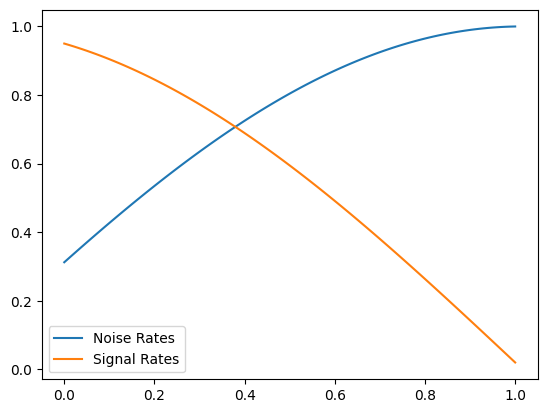

In [ ]:
import matplotlib.pyplot as plt

# 시각화
times = torch.linspace(0, 1, 100)
noise_rates, signal_rates = offset_cosine_diffusion_schedule(times)

plt.plot(times.cpu(), noise_rates.cpu(), label="Noise Rates")
plt.plot(times.cpu(), signal_rates.cpu(), label="Signal Rates")
plt.legend()
plt.show()

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, input_channels, output_channels):
        super(ResidualBlock, self).__init__()

        self.skip = nn.Sequential(
            nn.Conv2d(input_channels, output_channels, kernel_size=1)
        )

        self.main = nn.Sequential(
            nn.BatchNorm2d(input_channels, affine=False),
            nn.Conv2d(input_channels, output_channels, kernel_size=3, padding=1),
            nn.SiLU(),
            nn.Conv2d(output_channels, output_channels, kernel_size=3, padding=1),
        )

    def forward(self, x):
        residual = self.skip(x)
        out = self.main(x)

        out += residual

        return out


class DownBlock(nn.Module):
    def __init__(self, block_input_channels, output_channel, skip_stack):
        super(DownBlock, self).__init__()

        self.skip_stack = skip_stack

        self.blocks = nn.ModuleList(
            [
                ResidualBlock(block_input_channel, output_channel)
                for block_input_channel in block_input_channels
            ]
        )
        self.pool = nn.AvgPool2d(kernel_size=2)

    def forward(self, x):
        for block in self.blocks:
            x = block(x)
            self.skip_stack.append(x)

        x = self.pool(x)
        return x


class UpBlock(nn.Module):
    def __init__(self, block_input_channels, output_channel, skip_stack):
        super(UpBlock, self).__init__()

        self.skip_stack = skip_stack

        self.upsample = nn.UpsamplingBilinear2d(scale_factor=2)
        self.blocks = nn.ModuleList(
            [
                ResidualBlock(block_input_channel, output_channel)
                for block_input_channel in block_input_channels
            ]
        )

    def forward(self, x):
        x = self.upsample(x)

        for block in self.blocks:
            x = torch.cat([x, self.skip_stack.pop()], dim=1)
            x = block(x)

        return x


def sinusoidal_embedding(x):
    frequencies = (
        torch.exp(
            torch.linspace(
                math.log(1.0),
                math.log(1000.0),
                16,
            )
        )
        .view(1, -1, 1, 1)
        .to(device)
    )

    angular_speeds = 2.0 * math.pi * frequencies
    x = x.view(-1, 1, 1, 1)
    embeddings = torch.cat(
        [torch.sin(angular_speeds * x), torch.cos(angular_speeds * x)], dim=1
    )

    return embeddings


class UNet(nn.Module):
    def __init__(self, device="cuda"):
        super(UNet, self).__init__()

        self.skip_stack = []

        self.noisy_image_conv = nn.Conv2d(3, 32, kernel_size=1)
        self.noise_upsample = nn.UpsamplingNearest2d(size=64)

        self.down_blocks = nn.Sequential(
            DownBlock(
                block_input_channels=[64, 64],
                output_channel=64,
                skip_stack=self.skip_stack,
            ),
            DownBlock(
                block_input_channels=[64, 96],
                output_channel=96,
                skip_stack=self.skip_stack,
            ),
            DownBlock(
                block_input_channels=[96, 128],
                output_channel=128,
                skip_stack=self.skip_stack,
            ),
        )

        self.residual_blocks = nn.Sequential(
            ResidualBlock(128, 164),
            ResidualBlock(164, 164),
        )

        self.up_blocks = nn.Sequential(
            UpBlock(
                block_input_channels=[292, 256],
                output_channel=128,
                skip_stack=self.skip_stack,
            ),
            UpBlock(
                block_input_channels=[224, 192],
                output_channel=96,
                skip_stack=self.skip_stack,
            ),
            UpBlock(
                block_input_channels=[160, 128],
                output_channel=64,
                skip_stack=self.skip_stack,
            ),
        )

        self.conv_fc = nn.Conv2d(64, 3, kernel_size=1)

    def forward(self, noise_variances, noisy_images):
        noise_variances = noise_variances.view(-1, 1, 1, 1)
        noise_embedding = sinusoidal_embedding(noise_variances)
        noise_embedding = self.noise_upsample(noise_embedding)

        noisy_images = self.noisy_image_conv(noisy_images)

        x = torch.cat([noise_embedding, noisy_images], dim=1)

        x = self.down_blocks(x)
        x = self.residual_blocks(x)
        x = self.up_blocks(x)
        x = self.conv_fc(x)

        return x